In [1]:
!pip install gym torch

In [2]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

In [3]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        sample = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*sample)
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.int64),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32),
        )

    def __len__(self):
        return len(self.buffer)

# class PrioritizedReplayBuffer:
#     def __init__(self, capacity, alpha=0.6):
#         self.capacity = capacity
#         self.buffer = []
#         self.priorities = np.zeros((capacity,), dtype=np.float32)
#         self.position = 0
#         self.alpha = alpha  # Controls the importance of priorities; 0.6 is commonly used

#     def push(self, state, action, reward, next_state, done):
#         max_priority = self.priorities.max() if self.buffer else 1.0
#         if len(self.buffer) < self.capacity:
#             self.buffer.append((state, action, reward, next_state, done))
#         else:
#             self.buffer[self.position] = (state, action, reward, next_state, done)

#         self.priorities[self.position] = max_priority  # New experience starts with max priority
#         self.position = (self.position + 1) % self.capacity

#     def sample(self, batch_size, beta=0.4):
#         if len(self.buffer) == self.capacity:
#             priorities = self.priorities
#         else:
#             priorities = self.priorities[:self.position]

#         # Calculate probabilities proportional to priorities
#         probabilities = priorities ** self.alpha
#         probabilities /= probabilities.sum()

#         # Sample indices based on priorities
#         indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)
#         samples = [self.buffer[idx] for idx in indices]

#         # Calculate importance-sampling weights
#         total = len(self.buffer)
#         weights = (total * probabilities[indices]) ** (-beta)
#         weights /= weights.max()  # Normalize for stability

#         # Extract sampled experiences
#         states, actions, rewards, next_states, dones = zip(*samples)
#         return (
#             torch.tensor(states, dtype=torch.float32),
#             torch.tensor(actions, dtype=torch.int64),
#             torch.tensor(rewards, dtype=torch.float32),
#             torch.tensor(next_states, dtype=torch.float32),
#             torch.tensor(dones, dtype=torch.float32),
#             torch.tensor(weights, dtype=torch.float32),
#             indices  # Return indices for updating priorities later
#         )

#     def update_priorities(self, batch_indices, batch_priorities):
#         for idx, priority in zip(batch_indices, batch_priorities):
#             self.priorities[idx] = priority

#     def __len__(self):
#         return len(self.buffer)


In [22]:
def train_step(algo='DQN'):
    if len(replay_buffer) < batch_size:
        return

    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

    # Compute Q-values for the current states and the selected actions
    q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    # Compute Q-values for the next states using the target network
    if algo=='DQN':
      next_q_values = target_net(next_states).max(1)[0]
    elif algo == 'DDQN':
      next_actions = policy_net(next_states).argmax(1)
      next_q_values = target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)


    target_q_values = rewards + gamma * next_q_values * (1 - dones)

    # Compute loss and optimize
    loss = nn.functional.mse_loss(q_values, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# def train_step(algo='DQN', beta=0.4):
#     if len(replay_buffer) < batch_size:
#         return

#     # Sample with importance weights and indices
#     states, actions, rewards, next_states, dones, weights, indices = replay_buffer.sample(batch_size, beta=beta)

#     # Compute Q-values for the current states and selected actions
#     q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

#     # Compute Q-values for the next states using the target network
#     if algo == 'DQN':
#         next_q_values = target_net(next_states).max(1)[0]
#     elif algo == 'DDQN':
#         next_actions = policy_net(next_states).argmax(1)
#         next_q_values = target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)

#     target_q_values = rewards + gamma * next_q_values * (1 - dones)

#     # Compute TD errors and loss
#     td_errors = target_q_values - q_values
#     loss = (weights * td_errors.pow(2)).mean()

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     # Update priorities based on absolute TD errors (adding a small constant for stability)
#     new_priorities = td_errors.abs().detach().numpy() + 1e-6
#     replay_buffer.update_priorities(indices, new_priorities)


In [23]:
gamma = 0.99
batch_size = 64
lr = 0.001
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
target_update = 10
buffer_capacity = 10000
num_episodes = 1000

In [25]:
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=lr)
# replay_buffer = PrioritizedReplayBuffer(buffer_capacity, alpha=1)
replay_buffer = ReplayBuffer(buffer_capacity)

In [26]:
# Initialize logging lists
episode_rewards = []
frames_seen = []
total_frames = 0

# Initialize beta parameters for annealing
# beta_start = 0.8
# beta_frames = 100000  # Number of frames over which beta is annealed to 1.0

for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0
    episode_steps = 0

    # Calculate beta for this episode (incrementally increase towards 1)
    # beta = min(1.0, beta_start + total_frames / beta_frames)

    while not done:
        # Epsilon-greedy action selection
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                action = policy_net(torch.tensor(state, dtype=torch.float32)).argmax().item()

        # Take action and observe reward and next state
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        episode_steps += 1

        # Store the experience in the prioritized replay buffer
        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state

        # Perform a training step with prioritized replay
        # train_step(algo='DDQN', beta=beta)
        train_step(algo='DDQN')

    # Update epsilon for exploration decay
    epsilon = max(epsilon * epsilon_decay, epsilon_min)

    # Update the target network periodically
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Log rewards and frames for this episode
    episode_rewards.append(total_reward)
    total_frames += episode_steps
    frames_seen.append(total_frames)

    # Print episode summary
    print(f"Episode {episode}, Total Reward: {total_reward}, Total Frames: {total_frames}")


Episode 0, Total Reward: 25.0, Total Frames: 25
Episode 1, Total Reward: 45.0, Total Frames: 70
Episode 2, Total Reward: 71.0, Total Frames: 141
Episode 3, Total Reward: 14.0, Total Frames: 155
Episode 4, Total Reward: 14.0, Total Frames: 169
Episode 5, Total Reward: 23.0, Total Frames: 192
Episode 6, Total Reward: 16.0, Total Frames: 208
Episode 7, Total Reward: 13.0, Total Frames: 221
Episode 8, Total Reward: 17.0, Total Frames: 238
Episode 9, Total Reward: 11.0, Total Frames: 249
Episode 10, Total Reward: 15.0, Total Frames: 264
Episode 11, Total Reward: 15.0, Total Frames: 279
Episode 12, Total Reward: 15.0, Total Frames: 294
Episode 13, Total Reward: 17.0, Total Frames: 311
Episode 14, Total Reward: 11.0, Total Frames: 322
Episode 15, Total Reward: 11.0, Total Frames: 333
Episode 16, Total Reward: 43.0, Total Frames: 376
Episode 17, Total Reward: 24.0, Total Frames: 400
Episode 18, Total Reward: 33.0, Total Frames: 433
Episode 19, Total Reward: 30.0, Total Frames: 463
Episode 20, 

In [27]:
import numpy as np

np.save("episode_rewards_DDQN.npy", episode_rewards)
np.save("frames_seen_DDQN.npy", frames_seen)

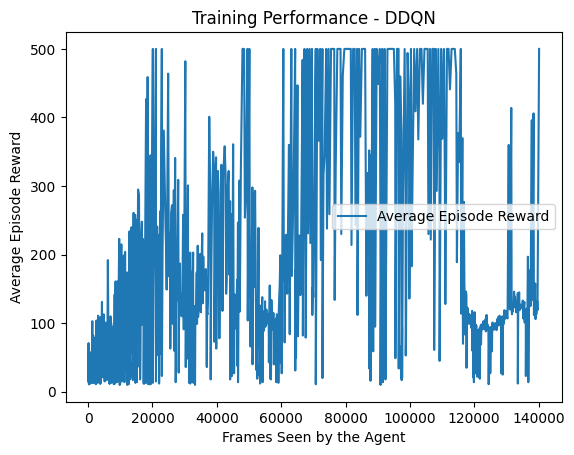

In [28]:
import matplotlib.pyplot as plt

# Plotting Average Episode Reward vs. Frames Seen
plt.plot(frames_seen, episode_rewards, label="Average Episode Reward")
plt.xlabel("Frames Seen by the Agent")
plt.ylabel("Average Episode Reward")
plt.title("Training Performance - DDQN")
plt.legend()
plt.show()


In [29]:
# Calculate the average reward over all episodes
average_reward = sum(episode_rewards) / len(episode_rewards)
print(f"Average Reward across all episodes: {average_reward}")

# Calculate the average reward over the last 100 episodes
if len(episode_rewards) >= 100:
    last_100_avg_reward = sum(episode_rewards[-100:]) / 100
    print(f"Average Reward over the last 100 episodes: {last_100_avg_reward}")


Average Reward across all episodes: 140.169
Average Reward over the last 100 episodes: 129.28


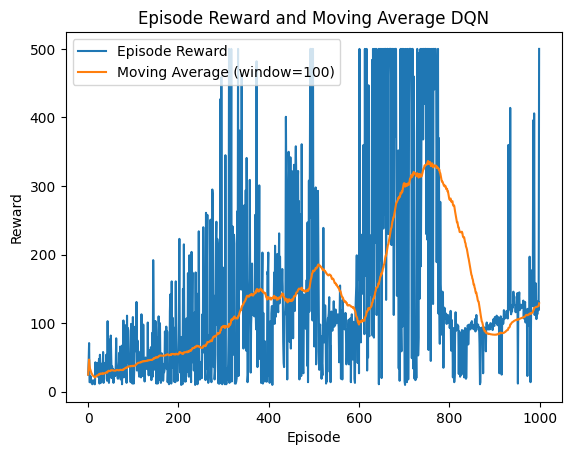

In [30]:
import matplotlib.pyplot as plt

# Calculate the moving average of the rewards (e.g., with a window size of 100)
window_size = 100
moving_avg_rewards = [np.mean(episode_rewards[max(0, i - window_size):(i + 1)]) for i in range(len(episode_rewards))]

# Plot
plt.plot(episode_rewards, label='Episode Reward')
plt.plot(moving_avg_rewards, label=f'Moving Average (window={window_size})')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Episode Reward and Moving Average DQN')
plt.legend()
plt.savefig('DDQN.png')
plt.show()


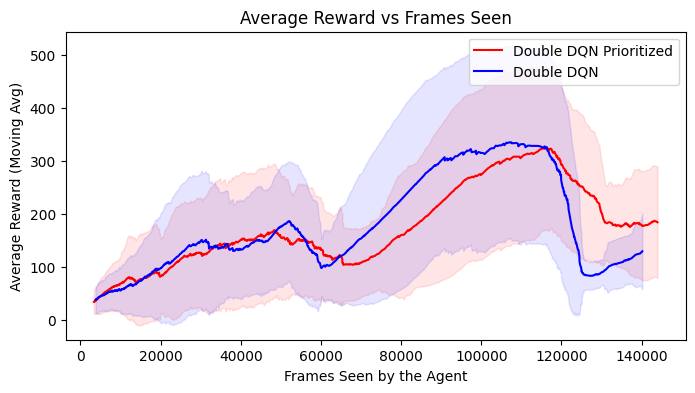

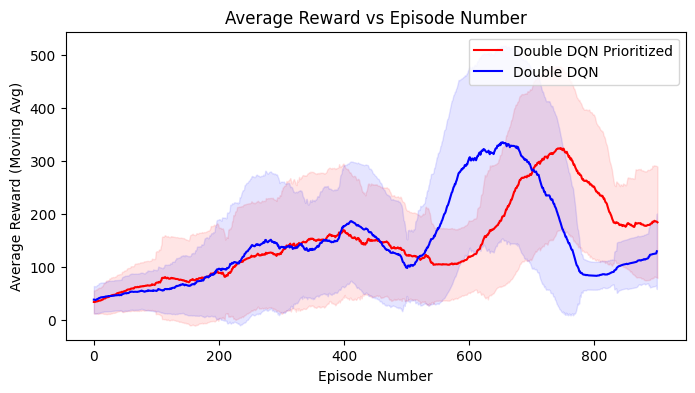

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Load the saved data for DQN and DDQN
episode_rewards_DQN = np.load("episode_rewards_DDQN_priority.npy")
frames_seen_DQN = np.load("frames_seen_DDQN_priority.npy")

episode_rewards_DDQN = np.load("episode_rewards_DDQN.npy")
frames_seen_DDQN = np.load("frames_seen_DDQN.npy")

# Calculate the moving average with a window size for smoother plots
window_size = 100

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

def moving_std(data, window_size):
    # Calculate rolling standard deviation over the moving window
    stds = [np.std(data[max(0, i - window_size):(i + 1)]) for i in range(len(data))]
    return np.array(stds[window_size - 1:])

# Calculate moving averages and standard deviations
moving_avg_rewards_DQN = moving_average(episode_rewards_DQN, window_size)
moving_avg_rewards_DDQN = moving_average(episode_rewards_DDQN, window_size)

std_rewards_DQN = moving_std(episode_rewards_DQN, window_size)
std_rewards_DDQN = moving_std(episode_rewards_DDQN, window_size)

# Adjust frames seen to match the moving average length
frames_seen_DQN_avg = frames_seen_DQN[window_size - 1:]
frames_seen_DDQN_avg = frames_seen_DDQN[window_size - 1:]

# Plot Average Reward vs Frames Seen with shading
plt.figure(figsize=(8, 4))
plt.plot(frames_seen_DQN_avg, moving_avg_rewards_DQN, label="Double DQN Prioritized", color='red')
plt.fill_between(frames_seen_DQN_avg,
                 moving_avg_rewards_DQN - std_rewards_DQN,
                 moving_avg_rewards_DQN + std_rewards_DQN,
                 color='red', alpha=0.1)
plt.plot(frames_seen_DDQN_avg, moving_avg_rewards_DDQN, label="Double DQN", color='blue')
plt.fill_between(frames_seen_DDQN_avg,
                 moving_avg_rewards_DDQN - std_rewards_DDQN,
                 moving_avg_rewards_DDQN + std_rewards_DDQN,
                 color='blue', alpha=0.1)
plt.xlabel("Frames Seen by the Agent")
plt.ylabel("Average Reward (Moving Avg)")
plt.title("Average Reward vs Frames Seen")
plt.legend()
plt.savefig('DDQN_vs_DDQN_priority_frames.png')
plt.show()

# Plot Average Reward vs Episode Number with shading
plt.figure(figsize=(8, 4))
plt.plot(moving_avg_rewards_DQN, label="Double DQN Prioritized", color='red')
plt.fill_between(range(len(moving_avg_rewards_DQN)),
                 moving_avg_rewards_DQN - std_rewards_DQN,
                 moving_avg_rewards_DQN + std_rewards_DQN,
                 color='red', alpha=0.1)
plt.plot(moving_avg_rewards_DDQN, label="Double DQN", color='blue')
plt.fill_between(range(len(moving_avg_rewards_DDQN)),
                 moving_avg_rewards_DDQN - std_rewards_DDQN,
                 moving_avg_rewards_DDQN + std_rewards_DDQN,
                 color='blue', alpha=0.1)
plt.xlabel("Episode Number")
plt.ylabel("Average Reward (Moving Avg)")
plt.title("Average Reward vs Episode Number")
plt.legend()
plt.savefig('DDQN_vs_DDQN_priority_episodes.png')
plt.show()
